The following function below is taken from [https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html](https://scipy-cookbook.readthedocs.io/items/BrownianMotion.html) and modified a bit. The delta, which determines the speed of the Brownian motion is set to 1. Therefore, the steps of each random walk is drawn from a Gaussian distribution with mean zero and variance equal to time step $\Delta$t. The initial value is included in the array unlike the solution given in the website. Including it or not does not change the calculation for P(X<0|y=0 for the first time) at all.

In [1]:
from math import sqrt
from scipy.stats import norm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time

sns.set(color_codes=True)
%matplotlib inline
seed = 1

In [2]:
def brownian(x0, n, dt, delta=1):
    """
    Generates an instance of Brownian motion (i.e. the Wiener process):

        X(t) = X(0) + N(0, delta**2 * t; 0, t)

    where N(a,b; t0, t1) is a normally distributed random variable with mean a and
    variance b.  The parameters t0 and t1 make explicit the statistical
    independence of N on different time intervals; that is, if [t0, t1) and
    [t2, t3) are disjoint intervals, then N(a, b; t0, t1) and N(a, b; t2, t3)
    are independent.
    
    Written as an iteration scheme,

        X(t + dt) = X(t) + N(0, delta**2 * dt; t, t+dt)


    If `x0` is an iterator, each value in `x0` is treated as
    an initial condition.

    Arguments
    ---------
    x0      : Numpy array or an iterator that can be converted to a numpy array
              using numpy.asarray(x0).
              The initial condition(s) (i.e. position(s)) of the Brownian motion in 2-D.
    n       : The number of steps to take.
    dt      : The time step.
    delta   : Determines the "speed" of the Brownian motion.  


    Returns
    -------
    A numpy array of shape=(x0.shape, n+1), which contains the position of the partcile at each time instant.
    
    Note that the initial value `x0` is included in the returned array.
    """

    x0 = np.asarray(x0)

    # For each element of x0, generate a sample of n numbers from a
    # normal distribution.
    r = norm.rvs(size=(x0.shape[0], n), scale=delta*sqrt(dt))
    r = np.hstack((x0.reshape(x0.shape[0],-1), r))

    # The result will be stored in out
    out = np.empty(r.shape)
    
    # This computes the Brownian motion by forming the cumulative sum of
    # the random samples. 
    np.cumsum(r, axis=-1, out=out)

    return out

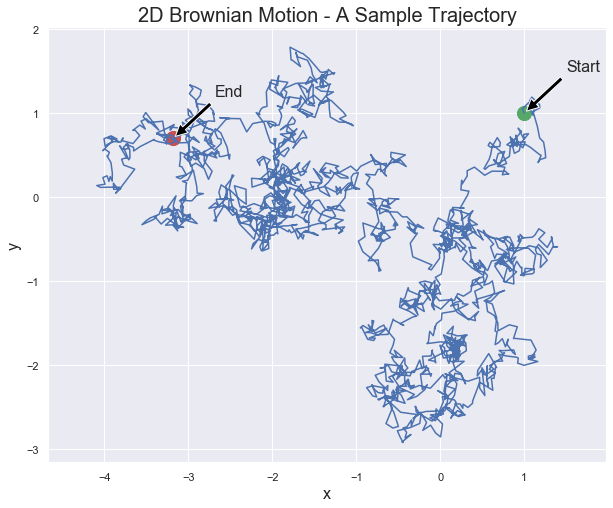

In [6]:
# Total time.
T = 10.0
# Number of steps.
N = 2000
# Time step size
dt = T/N
# Initial values of x.
x0 = [1,1]

x = brownian(x0, N, dt)

# Plot the 2D trajectory.
fig = plt.figure(figsize=(10,8))
plt.plot(x[0],x[1])

# Mark the start and end points.
plt.scatter(x[0,0],x[1,0], c='g', s=200)
plt.scatter(x[0,-1], x[1,-1], c='r', s=200)

plt.title('2D Brownian Motion - A Sample Trajectory', fontsize=20)
plt.annotate('Start', xy=(1, 1), xytext=(1.5, 1.5), fontsize=16,
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.annotate('End', xy=(x[0,-1], x[1,-1]), xytext=(x[0,-1]+0.5, x[1,-1]+0.5), fontsize=16,
            arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel('x', fontsize=16)
plt.ylabel('y', fontsize=16)
plt.axis('equal')
plt.grid(True)
plt.show()

Let's perform the simulations

In [13]:
# Total time.
T = 10.0
# Number of steps.
N = 2000
# Time step size
dt = T/N

# Variable to hold the number of times x is negative when the path crosses y=0 for the first time
totNeg = 0
# Variable to hold the number of times x is positive or zero when the path crosses y=0 for the first time
totPos = 0

# Number of times the simulatio will be run. The more is better
simNumber = 100000

start = time.time()
for sim in range(simNumber):
    
    x0 = [1,1]
    x = brownian(x0, N, dt)
    
    # The line below gives the index when it reaches exactly zero as well
    zero_crossings = np.where(np.diff(np.sign(x[1,:])))[0]
   
    if zero_crossings.size != 0:
        zeroCrossing = zero_crossings[0]
    
        # I took the crossing x value at one time step later. I do not expect this to have a huge impact on the 
        # probability calculations using this simulation
        if x[0,zeroCrossing+1] < 0:
            totNeg+=1
        else:
            totPos+=1
end = time.time()
print('Time needed for the simulations to complete: {:.2f} minutes\n'.format((end - start)/60))

print('The estimated probability of P(X<0|y=0 for the first time) is %.2f' %(totNeg/(totNeg+totPos)))    

Time needed for the simulations to complete: 0.31 minutes

The estimated probability of P(X<0|y=0 for the first time) is 0.19


Let's perform another simulation to get a feel of what the distribution may look like for P(X<x|y=0 for the first time) for different values of x. 

In [14]:
# Total time.
T = 10.0
# Number of steps.
N = 2000
# Time step size
dt = T/N

# Variable to hold the number of times x is negative when the path crosses y=0 for the first time
totNeg = 0
# Variable to hold the number of times x is positive or zero when the path crosses y=0 for the first time
totPos = 0

# Number of times the simulatio will be run. The more is better
simNumber = 10000
# x-axis coordinated to compare
xVal = np.linspace(-15,16,100)

prob = {}

start = time.time()
for T in xVal:
    
    # Variable to hold the number of times x is negative when the path crosses y=0 for the first time
    totNeg = 0
    # Variable to hold the number of times x is positive or zero when the path crosses y=0 for the first time
    totPos = 0

    for sim in range(simNumber):

        x0 = [1,1]
        x = brownian(x0, N, dt)

        # The line below gives the index when it reaches exactly zero as well
        zero_crossings = np.where(np.diff(np.sign(x[1,:])))[0]

        if zero_crossings.size != 0:
            zeroCrossing = zero_crossings[0]

            # I took the crossing x value at one time step later. I do not expect this to have a huge impact on the 
            # probability calculations using this simulation
            if x[0,zeroCrossing+1] < T:
                totNeg+=1
            else:
                totPos+=1
                
    prob[T] = totNeg/(totNeg+totPos)
end = time.time()
print('Time needed for the simulations to complete: {:.2f} minutes\n'.format((end - start)/60))

Time needed for the simulations to complete: 3.10 minutes



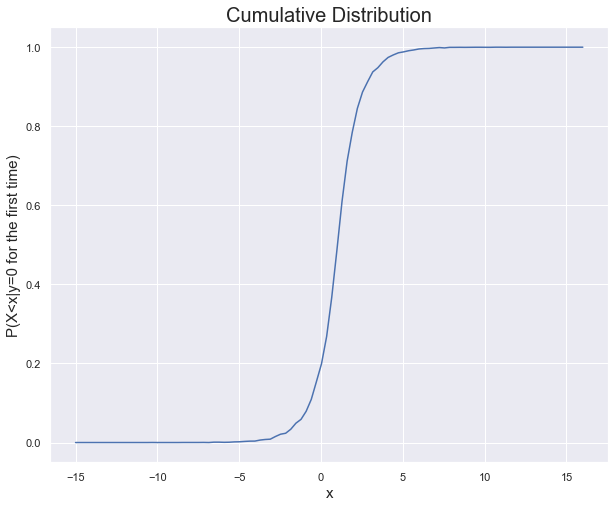

In [15]:
plt.figure(figsize=(10,8))
plt.plot(list(prob.keys()), list(prob.values())) 
plt.xlabel('x', fontsize=15)
plt.ylabel('P(X<x|y=0 for the first time)', fontsize=15)
plt.title('Cumulative Distribution', fontsize=20);

As can be seen from the figure above, the cumulative distribution approaches 1 for large values of x where the particle crosses the x-axis (y=0). The probability approaches zero for negative values of x. Since the initial position of the particle is (1,1), the value of P(X<1|y=0 for the first time) is estimated as 0.5 from the simulations as expected. The cumulative disribituiton looks like a sigmoid which is expected as well.    